# Example 5: Multi-state FBR-SOP tutorial (LVC model)

| run type      | wavefunction | backend | Basis  | steps |
| ---           | ---          | ---     | ---    | ---   |
| propagation | MPS-SM | Numpy   | HO-FBR | 200    |


## 1. Import modules

In [1]:
from discvar import PrimBas_HO

from pytdscf import BasInfo, Model, Simulator
from pytdscf.hamiltonian_cls import PolynomialHamiltonian

## 2. Define basis funciton
In this case, 2-state 3-mode simulation of N=10, ω1=1500 cm-1, ω2=2000 cm-1, ω3=2500 cm-1 are defined

In [2]:
freqs_cm1 = [1500, 2000, 2500]
disps = [0.3, 0.4, 0.5]
nprim = 10
s0 = [PrimBas_HO(0.0, freq, nprim) for freq in freqs_cm1]
s1 = [
    PrimBas_HO(disp, freq, nprim)
    for freq, disp in zip(freqs_cm1, disps, strict=False)
]  # S1 basis is displaced from S0 basis
basinfo = BasInfo([s0, s1])

## 3. Define Hamiltonian
In this case, Hamiltonian is defined by
$$
H=\left[\begin{array}{cc}
\sum_v-\frac{\omega_v}{2}\left(\frac{\partial^2}{\partial Q_v^2}+Q_v^2\right) & J_{12} + \sum_v \lambda_{12}^{(v)} Q_v\\
J_{21}  + \sum_v \lambda_{21}^{(v)} Q_v& \sum_v-\frac{\omega_v}{2}\left(\frac{\partial^2}{\partial Q_v^2}+ (Q_v - Q^{(0)})^2\right)+\Delta E
\end{array}\right].
$$

In [3]:
coupleJ = 0.0001  # J_12 and J_21 in a.u.
deltaE = 0.01  # ΔE in a.u.

hamiltonian = PolynomialHamiltonian(basinfo.get_ndof(), basinfo.get_nstate())
hamiltonian.coupleJ = [
    [-deltaE / 2, coupleJ],
    [coupleJ, deltaE / 2],
]  # Shifting diagonal term reduces the iteration of each step.

lam = {
    (0, 1): {0: 0.001, 1: 0.0001},
    (1, 0): {0: 0.001, 1: 0.0001},
}  # λ_12^(v) in Hartree / (sqrt(AMU) * Bohr)

hamiltonian.set_LVC(basinfo, lam)

operators = {"hamiltonian": hamiltonian}

## 4. Define misc
- MPS bond-dimension is m=4
- Initial population of 1-state is 1.0
- Initial vibrational state is $|0,0,0\rangle \otimes |1,0,0\rangle$ (only S0 state 0-th mode is excited)

In [4]:
model = Model(basinfo, operators)
model.m_aux_max = 4
model.init_weight_ESTATE = [0.0, 1.0]
vib_gs = [1.0] + [0.0] * 9
vib_es = [0.0] + [1.0] + [0.0] * 8
model.init_weight_VIB_GS = [[vib_gs, vib_gs, vib_gs], [vib_es, vib_gs, vib_gs]]
# model.primbas_gs = list(itertools.chain.from_iterable([s0 for _ in range(nmol)]))

## 5. Execute simulation
- Δt=0.1 fs
- If `proj_gs=True`, then the initial vibrational state is projected from `model.primbas_gs`.

In [5]:
jobname = "LVC"
backend = "numpy"
simulator = Simulator(jobname, model, backend=backend, proj_gs=False)
simulator.propagate(maxstep=200, stepsize=0.1)

2024-10-26 20:20:48,309 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-10-26 20:20:48,310 - INFO:main.pytdscf._const_cls - Log file is ./LVC_prop/main.log
2024-10-26 20:20:48,310 - INFO:main.pytdscf.simulator_cls - Set integral of FBR basis
2024-10-26 20:20:48,448 - INFO:main.pytdscf.simulator_cls - Set initial wave function (FBR basis)
2024-10-26 20:20:48,448 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-10-26 20:20:48,449 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 0.0
2024-10-26 20:20:48,449 - INFO:main.pytdscf._mps_cls - Initial MPS: 1-state with weights 1.0
2024-10-26 20:20:48,453 - INFO:main.pytdscf.simulator_cls - Wave function is saved in wf_LVC.pkl
2024-10-26 20:20:48,453 - INFO:main.

(0.018669005759725615, <pytdscf.wavefunction.WFunc at 0x1244aacf0>)

In [6]:
!cat LVC_prop/populations.dat

# time [fs]	pop_0      	pop_1      
0.000000000	0.000000000	1.000000000	
0.100000000	0.001514000	0.998486000	
0.200000000	0.006028346	0.993971654	
0.300000000	0.013461024	0.986538976	
0.400000000	0.023678470	0.976321530	
0.500000000	0.036500074	0.963499926	
0.600000000	0.051704140	0.948295860	
0.700000000	0.069034987	0.930965013	
0.800000000	0.088210837	0.911789163	
0.900000000	0.108932106	0.891067894	
1.000000000	0.130889748	0.869110252	
1.100000000	0.153773302	0.846226698	
1.200000000	0.177278383	0.822721617	
1.300000000	0.201113394	0.798886606	
1.400000000	0.225005317	0.774994683	
1.500000000	0.248704516	0.751295484	
1.600000000	0.271988515	0.728011485	
1.700000000	0.294664789	0.705335211	
1.800000000	0.316572583	0.683427417	
1.900000000	0.337583842	0.662416158	
2.000000000	0.357603259	0.642396741	
2.100000000	0.376567512	0.623432488	
2.200000000	0.394443690	0.605556310	
2.300000000	0.411226947	0.588773053	
2.400000000	0.426937427	0.573062573	
2.500000000	0.441616516	0.558383484	
2.

## 7. Visualize populations

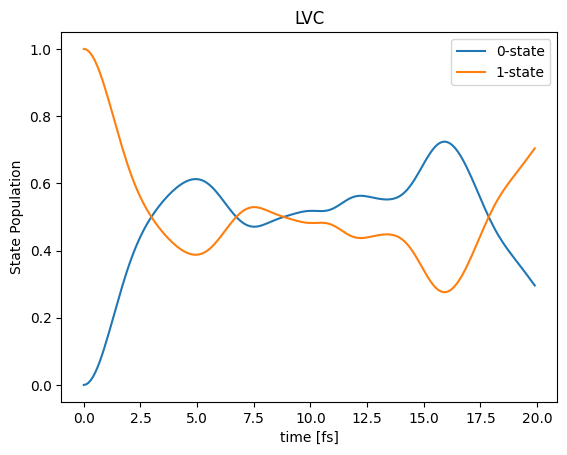

In [7]:
# !gnuplot -e " set xlabel 'time [fs]'; set ylabel 'population'; plot 'PropagateMultiStateSOP/populations.log' using 1:2 with lines title '0-state', 'PropagateMultiStateSOP/populations.log' using 1:3 with lines title '1-state'"
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt("LVC_prop/populations.dat")

plt.plot(data[:, 0], data[:, 1], label="0-state")
plt.plot(data[:, 0], data[:, 2], label="1-state")

plt.title(jobname)
plt.xlabel("time [fs]")
plt.ylabel("State Population")

plt.legend()
plt.show()